# Start dask

In [1]:
import dask.dataframe as dd
from dask.distributed import Client

#Initializing client
client = Client()
client

/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://127.0.0.1:49323 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


# Data
This notebook starts using 'is_json_above_bean.parquet', this is a filtered data that you can get by running the data preparation notebook called 'jsJson_dataPrep.ipynb'. 
This parquet contains the 10% sample data filtered by values above the mean of value_len. 

This new sample has 499805 rows, meaning that its only 4,42% of the original sample (most values are smaller than the sample's mean of 1356). 

In [2]:
df = dd.read_parquet('is_json_above_mean.parquet', columns=['value_len', 'is_json'])
df.head()

,value_len,is_json
0,3713,True
1,103878,True
2,103878,True
3,1358,False
4,1358,False


# Visualization: 

In [3]:
cdf = df.compute()

/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/worker.py:2791: UserWarning: Large object of size 1.89 MB detected in task graph: 
  (<dask.bytes.local.LocalFileSystem object at 0x121 ... n': 'is_json'})
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


The absolute majority of the values are on the small side for the sample (left side of graph below)

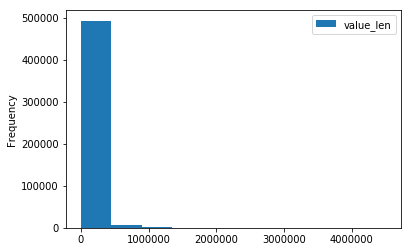

In [5]:
cdf['value_len'].plot(kind='hist', legend=True)

In [6]:
jsonGroup = cdf.groupby('is_json')

And we cannot identify any non_json (blue) on the right side of the histogram. This means there all frquency of non-json values are very low or inexistent for the biggest values. Since there are so many small values, the biggest ones represent such a small portion that is hard to identify by look on the histograms and graphs. 

is_json
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: value_len, dtype: object

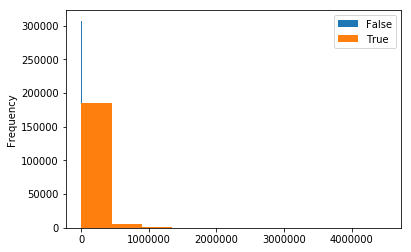

In [7]:
jsonGroup['value_len'].plot(kind='hist', legend=True)

## Sample overview
Some overview about the sample after the data prep: 
- Rows: 499805
- Mean: 27829.33,
- Min: 1357,
- Max: 4496861
- Std: 122092.41

In [8]:
#Hardcoded data to fast use, but your can update for the calculed value within the next few cells 
MEAN = 27829.33
MIN = 1357
MAX = 4496861
STD = 122092.41
COUNT = 499805

#Information for original sample.
ORIG_MEAN = 1356.97
ORIG_MIN = 0
ORIG_MAX = 4496861
ORIG_STD = 26310.62
ORIG_COUNT = 11292867

#hardcoded information about described data for values one std above the mean: 
A_MEAN = 271204.44
A_MIN = 27669
A_MAX = 4496861
A_STD = 306555
A_COUNT = 46745

In [9]:
def describedData(df):
    tmp_mean = df['value_len'].mean()
    tmp_min = df['value_len'].min()
    tmp_max = df['value_len'].max()
    tmp_std = df['value_len'].std()
    tmp_count = df['value_len'].count()
    (tmp_mean, tmp_min, tmp_max, tmp_std, tmp_count) = dd.compute(tmp_mean, tmp_min, tmp_max, tmp_std, tmp_count);
    return (tmp_mean, tmp_min, tmp_max, tmp_std, tmp_count)

In [10]:
#Calculate the described data for mean sample
(MEAN, MIN, MAX, STD, COUNT) = describedData(df)
print(MEAN, MIN, MAX, STD, COUNT)

27829.332847810645 1357 4496861 122092.41371885882 499805


In [11]:
#Calculate the described data for original sample
(ORIG_MEAN, ORIG_MIN, ORIG_MAX, ORIG_STD, ORIG_COUNT) = describedData(dd.read_parquet('sample_0.parquet'))
print(ORIG_MEAN, ORIG_MIN, ORIG_MAX, ORIG_STD, ORIG_COUNT)

1356.9776628910975 0 4496861 26310.62140481331 11292867


In [12]:
#Calculate the described data for one std above the mean (using mean and stf of the original sample)
std_above = df[df['value_len'] > ORIG_STD + ORIG_MEAN]
(A_MEAN, A_MIN, A_MAX, A_STD, A_COUNT) = describedData(std_above)
print(A_MEAN, A_MIN, A_MAX, A_STD, A_COUNT)

271204.44978072523 27669 4496861 306555.0273738244 46745


The following cell will create a dataframe of the described data calculated above and save it into a csv to fulture use, if calculations are not possible. 

In [28]:
# Comparasion of this sample and original 10% sample:
import pandas as pd
import numpy as np
%matplotlib inline

compare = pd.DataFrame([(ORIG_MEAN, ORIG_MIN, ORIG_MAX, ORIG_STD, ORIG_COUNT),
                        (MEAN, MIN, MAX, STD, COUNT), 
                        (A_MEAN, A_MIN, A_MAX, A_STD, A_COUNT)], 
                       columns=['MEAN', 'MIN', 'MAX', 'STD', 'COUNT'],
                      index= ['ORIGINAL','ABOVE_MEAN', 'ABOVE_STD'])
compare.to_csv('describedData.csv')
compare

,MEAN,MIN,MAX,STD,COUNT
ORIGINAL,1356.977663,0,4496861,26310.621405,11292867
ABOVE_MEAN,27829.332848,1357,4496861,122092.413719,499805
ABOVE_STD,271204.449781,27669,4496861,306555.027374,46745


# Number of rows
The number of rows after filtering for values above the mean are about 4.42% of the original sample.  
And the count for values one std above the mean is just 9.35% of this sample or 0.41% of original sample.  
By this we can see that the really big values represent just a very small portion of the whole. 

In [14]:
print('Above the mean / original', COUNT / ORIG_COUNT * 100)
print('1 STD Above the mean / original', A_COUNT / ORIG_COUNT * 100)
print('1 STD Above the mean / Above mean', A_COUNT / COUNT * 100)

Above the mean / original 4.425846864219688
1 STD Above the mean / original 0.41393385754033946
1 STD Above the mean / Above mean 9.35264753253769


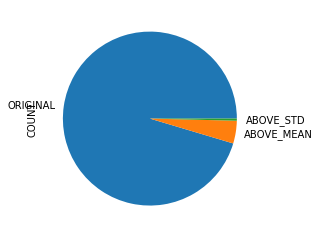

In [15]:
compare['COUNT'].plot(kind='pie')

# Max and Min values

it is expected that the maximum will be the same for all mentioned samples since the filtering is being made by the minimum, and is also expected that the min is the value used to filter.

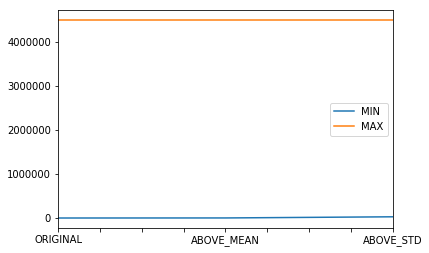

In [16]:
compare[['MIN','MAX']].plot()

# Mean and Std
> A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values. (https://en.wikipedia.org/wiki/Standard_deviation)

It is noticeable that both mean and std are increassing as the data is filtered by bigger values. 

The increase of the mean is to be expected, since we are eliminating the smaller values and leaving only the bigger ones. 

But the STD is not necessary like the mean where it will increase after the filter, but since it is the case here we can safaly assume that as the values get bigger the more spread out they are, the mean of the sample is less accurate to represent the whole dataset since they have a huge difference of value from one another. 

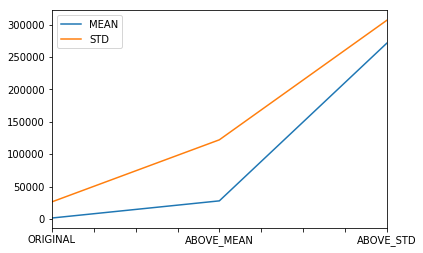

In [17]:
compare[['MEAN','STD']].plot()

# IS JSON

This whole sample has: 
- False: 307577 rows
    - 61,54% are not valid JSON
    
- True: 192228 rows
    - 38,46% are valid JSON

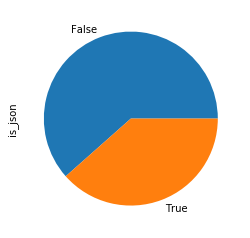

In [18]:
is_json_counts = df['is_json'].value_counts().compute()
is_json_counts.plot(kind='pie')

As the value_len increases the frequence of valid JSON on the columns 'value' also increases,
for the rows that have the value_len one std above the mean, we have the following:
- isJson True: 46691 rows
    - 99,88% are valid JSON
    
- isJson False: 54 rows
    - 0,11% are not valid JSON


The valid json also represent 9.35% of the data because the number of non Json are too small to make a percentual difference. 

In [19]:
print("one std above the mean = len: {0} ({1:0.2f}%)".format(A_COUNT, A_COUNT / COUNT * 100))

one std above the mean = len: 46745 (9.35%)


In [20]:
group = std_above.groupby('is_json')
group_result = group.agg({'value_len': ['mean', 'std', 'min', 'max', 'count']}).compute()
group_result

value_len                                      
                  mean            std    min      max  count
is_json                                                     
False     82460.055556   13627.118063  28135   104653     54
True     271422.740185  412552.298613  27669  4496861  46691

In [21]:
a = group_result['value_len']['count']
print("NOT json count: {0} ({1:0.2f}%)".format(a[0], a[0] / COUNT * 100))
print("IS json count: {0} ({1:0.2f}%)".format(a[1], a[1] / COUNT * 100))

NOT json count: 54 (0.01%)
IS json count: 46691 (9.34%)


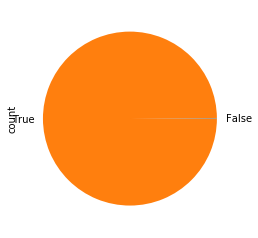

In [22]:
group_result['value_len']['count'].plot(kind='pie')

### All greater values are JSON

There is absolute no value greater than 104653 (max value for non-json) that represents a valid JSON. 

This implies that all the greater values are JSON but they represent very low percentage of the whole data (6.76%).  

In [26]:
max_non_json_value = group_result['value_len']['max'][0]
allJson = df[df['value_len'] > max_non_json_value ]
length = len(allJson)
print("len: {0} ({1:0.2f}%)".format(length, length / COUNT * 100))

104653
len: 33788 (6.76%)
